In [5]:
from __future__ import division, print_function

# Standard lib
import time

# Third-party
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Custom
import gary.coordinates as gc
import gary.dynamics as gd
import gary.integrate as gi
import gary.io as io
import gary.potential as gp
from gary.units import galactic

# project
from streammorphology.ensemble import fast_ensemble, create_ball, align_ensemble, nearest_pericenter
from streammorphology.freqmap import read_allfreqs, estimate_dt_nsteps, estimate_periods
from streammorphology.potential import potential_registry

potential = potential_registry['triaxial-NFW']

Colors to plot regular and chaotic orbit

In [6]:
reg_c = 'k'
# cha_c = '#2166AC' # blue
cha_c = '#B2182B' # red
cs = [reg_c, cha_c]

#### Initial conditions for the two orbits - pulled from "Balls of particles" notebook

In [7]:
slow_fast_w0 = np.array([[22.76, 0.0, 18.8, 0.0, 0.15610748624460613, 0.0],
 [22.76, 0.0, 19.680000000000003, 0.0, 0.15086768887859237, 0.0]])

#### Parameters for integration

In [8]:
nsteps_per_period = 250
nperiods = 1000

#### Orbital periods measured from a previous run, used to estimate the integration time

In [9]:
dt,nsteps = estimate_dt_nsteps(potential, slow_fast_w0[0], nperiods, nsteps_per_period)
print("{0} steps, ∆t = {1:.2f}".format(nsteps,dt))

530000 steps, ∆t = 1.67


In [10]:
t1 = time.time()
t,w = potential.integrate_orbit(slow_fast_w0, dt=dt, nsteps=nsteps,
                                Integrator=gi.DOPRI853Integrator)
print("Took {:.1f} seconds to integrate".format(time.time() - t1))

Took 2.7 seconds to integrate


In [11]:
loop = gd.classify_orbit(w)
loop

array([[0, 0, 1],
       [0, 0, 0]])

In [13]:
T1 = estimate_periods(t, w[:,0])
T2 = estimate_periods(t, w[:,1])
T1,T2

(array([ 417.75631166,  893.27508508,  835.52562451]),
 array([ 884.39137802,  864.60317194,  847.48039751]))

In [73]:
# np.save("/Users/adrian/projects/gary/test-data/naff/w.npy", w[:,1])
# np.save("/Users/adrian/projects/gary/test-data/naff/t.npy", t)

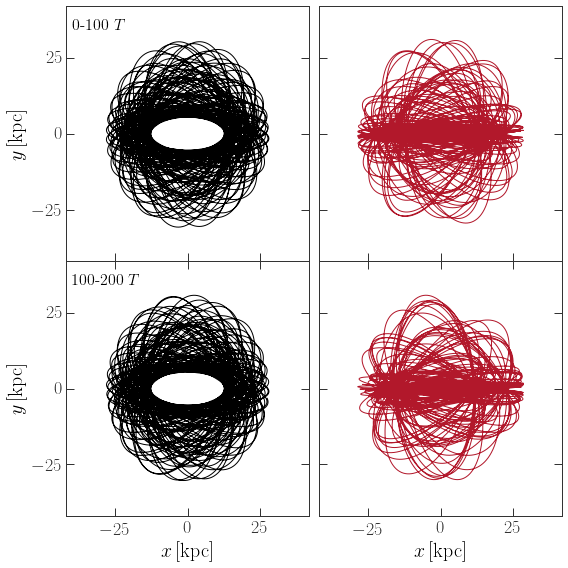

In [74]:
fig,axes = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)

plotix = (0,1) # x,y
# plotix = (1,2) # y,z
nplot = int(100*T.max()/dt)

for i in range(2):
    axes[0,i].plot(w[:nplot,i,plotix[0]], w[:nplot,i,plotix[1]], 
                   marker=None, linestyle='-', alpha=1., c=cs[i])
    axes[1,i].plot(w[nplot:2*nplot,i,plotix[0]], w[nplot:2*nplot,i,plotix[1]], 
                   marker=None, linestyle='-', alpha=1., c=cs[i])
    
    axes[0,i].set_xticks([-25,0,25])
    axes[1,i].set_xticks([-25,0,25])
    axes[0,i].set_yticks([-25,0,25])
    axes[1,i].set_yticks([-25,0,25])
    
#     axes[0,i].plot(w[:nplot,i,ix[0]], w[:nplot,i,ix[1]], 
#                    marker='.', linestyle='none', alpha=0.1, c=cs[i])
#     axes[1,i].plot(w[-nplot:,i,ix[0]], w[-nplot:,i,ix[1]], 
#                    marker='.', linestyle='none', alpha=0.1, c=cs[i])
    
axes[0,0].set_xlim(-42,42)
axes[0,0].set_ylim(-42,42)
    
axes[0,0].text(-40, 34, r"0-100 $T$", fontsize=16)
axes[1,0].text(-40, 34, r"100-200 $T$", fontsize=16)
    
axes[0,0].set_ylabel(r"$y \, [{\rm kpc}]$", fontsize=20)
axes[1,0].set_ylabel(r"$y \, [{\rm kpc}]$", fontsize=20)
axes[1,0].set_xlabel(r"$x \, [{\rm kpc}]$", fontsize=20)
axes[1,1].set_xlabel(r"$x \, [{\rm kpc}]$", fontsize=20)
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.)

# fig.savefig("/Users/adrian/papers/papers/stream-morphology/figures/two-orbits.pdf")

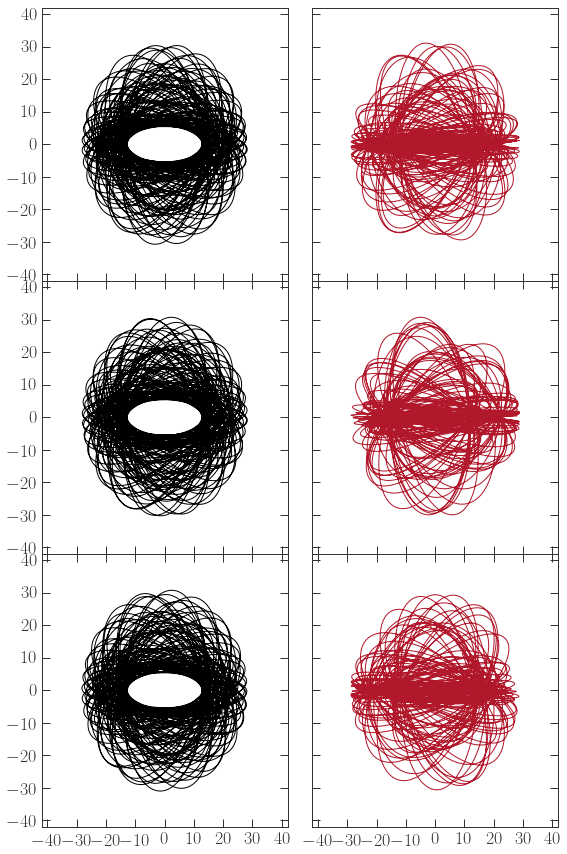

In [75]:
fig,axes = plt.subplots(3,2,figsize=(8,12),sharex=True,sharey=True)

for i in range(2):
    derp = w.shape[0] // 10
    for j in range(3):
        axes[j,i].plot(w[j*derp:(j+1)*derp,i,plotix[0]], w[j*derp:(j+1)*derp,i,plotix[1]], 
                       marker=None, linestyle='-', alpha=1., c=cs[i])

axes[0,0].set_xlim(-42,42)
axes[0,0].set_ylim(-42,42)
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.)

## Frequency Diffusion

In [76]:
f_nsteps = nsteps // 4
df_nsteps = f_nsteps // 8
print(nperiods // 4)

250


In [77]:
xxx = np.arange(0,nsteps-f_nsteps+1,df_nsteps).astype(int)
f_ixes = zip(xxx, xxx+f_nsteps)
# for i1,i2 in f_ixes:
#     print(i1,i2)

In [53]:
slow_freqs = list()
for i1,i2 in f_ixes:
    i2 += 1
    print(i1,i2)
    naff = gd.NAFF(t[i1:i2:2])
    new_w = gd.align_circulation_with_z(w[:,0],loop[0])
    new_w = gc.poincare_polar(new_w[i1:i2:2])
    fs = [(new_w[:,i]+1j*new_w[:,i+3]) for i in range(3)]
    freqs,d,ixes = naff.find_fundamental_frequencies(fs, nintvec=5)
    print(np.abs(freqs))
    slow_freqs.append(np.abs(freqs).tolist())
slow_freqs = np.array(slow_freqs)

0 132501
[ 0.01503996  0.0070339   0.00751998]
16562 149063
[ 0.01503996  0.0070339   0.00751998]
33124 165625
[ 0.01503996  0.0070339   0.00751998]
49686 182187
[ 0.01503996  0.0070339   0.00751998]
66248 198749
[ 0.01503996  0.0070339   0.00751998]
82810 215311
[ 0.01503996  0.0070339   0.00751998]
99372 231873
[ 0.01503996  0.0070339   0.00751998]
115934 248435
[ 0.01503996  0.0070339   0.00751998]
132496 264997
[ 0.01503996  0.0070339   0.00751998]
149058 281559
[ 0.01503996  0.0070339   0.00751998]
165620 298121
[ 0.01503996  0.0070339   0.00751998]
182182 314683
[ 0.01503996  0.0070339   0.00751998]
198744 331245
[ 0.01503996  0.0070339   0.00751998]
215306 347807
[ 0.01503996  0.0070339   0.00751998]
231868 364369
[ 0.01503996  0.0070339   0.00751998]
248430 380931
[ 0.01503996  0.0070339   0.00751998]
264992 397493
[ 0.01503996  0.0070339   0.00751998]
281554 414055
[ 0.01503996  0.0070339   0.00751998]
298116 430617
[ 0.01503996  0.0070339   0.00751998]
314678 447179
[ 0.01503

In [54]:
# Should be ~2E-8?
np.std(slow_freqs, axis=0) 

array([  1.72672325e-10,   4.74955078e-11,   1.11943040e-10])

In [78]:
fast_freqs = list()
for i1,i2 in f_ixes:
    i2 += 1
    print(i1,i2)
    naff = gd.NAFF(t[i1:i2])
#     new_w = gd.align_circulation_with_z(w[i1:i2,1],loop[1])
#     new_w = gc.poincare_polar(new_w)
    new_w = w[i1:i2,1]
    fs = [(new_w[:,i]+1j*new_w[:,i+3]) for i in range(3)]
    freqs,d,ixes = naff.find_fundamental_frequencies(fs, nintvec=5)
#     freqs,d,ixes,is_tube = gd.naff.orbit_to_freqs(t[i1:i2:2], w[i1:i2:2,1], silently_fail=False, nintvec=5)
    print(np.abs(freqs))
    fast_freqs.append(np.abs(freqs).tolist())
fast_freqs = np.array(fast_freqs)

0 132501
[ 0.0071117   0.00740774  0.00740613]
16562 149063
[ 0.00711077  0.00741644  0.00740699]
33124 165625
[ 0.007111    0.00743392  0.00740689]
49686 182187
[ 0.00711187  0.00743973  0.0074062 ]
66248 198749
[ 0.00711191  0.00744675  0.00740617]
82810 215311
[ 0.00710953  0.00745175  0.0074084 ]
99372 231873
[ 0.007106    0.00744811  0.00741175]
115934 248435
[ 0.00710359  0.00743836  0.00741404]
132496 264997
[ 0.00710336  0.00677575  0.00741418]
149058 281559
[ 0.00710358  0.00743896  0.00741388]
165620 298121
[ 0.00710079  0.00744865  0.00741653]
182182 314683
[ 0.00709541  0.00745414  0.00742175]
198744 331245
[ 0.00709329  0.00745609  0.0074238 ]
215306 347807
[ 0.00709806  0.00745587  0.00741911]
231868 364369
[ 0.00710646  0.00745801  0.0074111 ]
248430 380931
[ 0.00710998  0.00746594  0.00740815]
264992 397493
[ 0.0071086   0.00705378  0.0074101 ]
281554 414055
[ 0.00710693  0.00705992  0.00741195]
298116 430617


ERROR: RuntimeError: Frequency optimizer hit bound. [IPython.core.interactiveshell]


RuntimeError: Frequency optimizer hit bound.

In [79]:
# should be ~2-3E-5
fast_freqs = np.array(fast_freqs)
np.std(fast_freqs, axis=0)

array([  5.61244989e-06,   1.87711537e-04,   5.28923432e-06])

In [80]:
sorted_ixes = d[ixes]['|A|'].argsort()[::-1]
print(sorted_ixes)

[2 0 1]


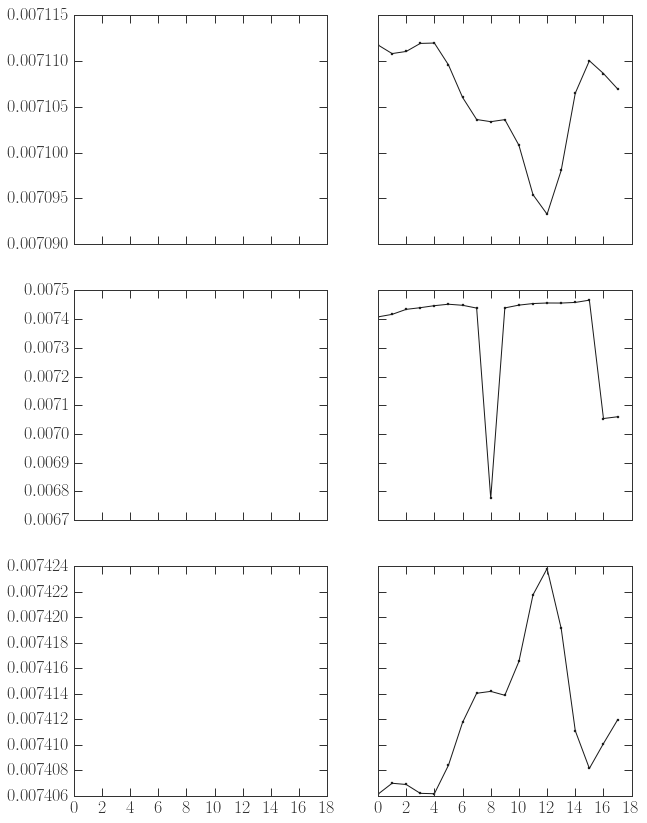

In [81]:
fig,axes = plt.subplots(3,2,figsize=(10,14),sharex=True, sharey='row')

for i,row in enumerate(axes):
#     row[0].plot(slow_freqs[:,i])
    row[1].plot(fast_freqs[:,i])

# axes[0].set_xlim(0.62,0.635)
# axes[0].set_ylim(0.665,0.68)

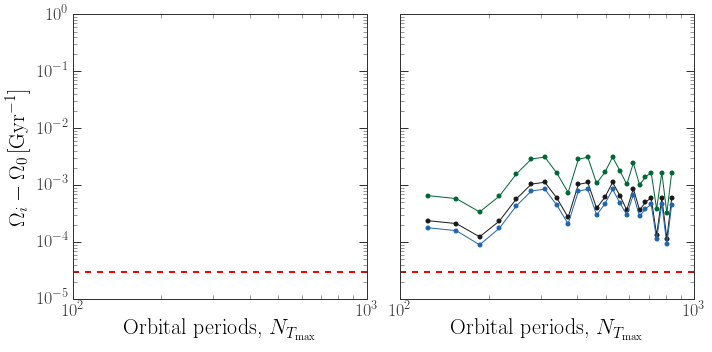

In [60]:
fig,axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

# axes[0].plot(slow_freqs[:,1]/slow_freqs[:,0], slow_freqs[:,2]/slow_freqs[:,0], 
#              marker='.', linestyle='-')

# axes[1].plot(fast_freqs[:,1]/fast_freqs[:,0], fast_freqs[:,2]/fast_freqs[:,0], 
#              marker='.', linestyle='-')

tttt = np.array([(derp[0]+derp[1])/2. for derp in f_ixes])*dt / T.max()

for i,f in enumerate([slow_freqs, fast_freqs]):
    for j in range(3):
#         mean_f = f[1:,sorted_ixes[j]].mean()
        # mean_f = f[0,sorted_ixes[j]]
        # max_x = (f[1:,sorted_ixes[j]] - mean_f) # / mean_f * 100.
        max_x = f[1:,sorted_ixes[j]] - f[:-1,sorted_ixes[j]]
        axes[i].loglog(tttt[:-1], np.abs(max_x)*1000., marker='o', linestyle='-')
    
axes[0].axhline(3E-8*1000., linestyle='dashed', linewidth=2., c='r')
axes[1].axhline(3E-8*1000., linestyle='dashed', linewidth=2., c='r')
# axes[1].plot(fast_freqs[:,1]*1000, fast_freqs[:,2]*1000, 
#              marker='o', linestyle='-')

# axes[0].set_ylabel(r"$\Delta\Omega_i/\Omega_i \times \, 100$")
axes[0].set_ylabel(r"$\Omega_i-\Omega_0 \, [{\rm Gyr}^{-1}]$")
axes[0].set_xlabel(r"Orbital periods, $N_{T_{\rm max}}$")
axes[1].set_xlabel(r"Orbital periods, $N_{T_{\rm max}}$")

axes[0].set_ylim(1E-8*1000., 1E-3*1000.)
# axes[0].set_xlim(0,10)

fig.tight_layout()
# fig.savefig("/Users/adrian/papers/papers/stream-morphology/figures/freq-diff-orbits.pdf")

## Lyapunov exponent

Get maximum period to convert time into number of orbital periods

In [61]:
# slow_T_max = 2*np.pi / slow_freqs[0].min()
# fast_T_max = 2*np.pi / fast_fraeqs[0].min()

In [62]:
sl_LEs, sl_lyap_ts, sl_lyap_ws = gd.fast_lyapunov_max(slow_fast_w0[0], potential, dt=2., nsteps=700000)
fa_LEs, fa_lyap_ts, fa_lyap_ws = gd.fast_lyapunov_max(slow_fast_w0[1], potential, dt=2., nsteps=700000)

In [63]:
sl_ix = sl_LEs[-1].argmax()
fa_ix = fa_LEs[-1].argmax()

In [64]:
sl_lyap_ts.shape, sl_LEs.shape

((70000,), (69999, 2))

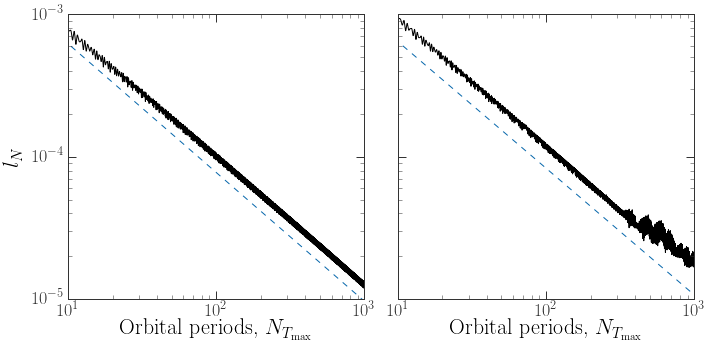

In [65]:
fig,axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

axes[0].loglog(sl_lyap_ts[1:] / T.max(), sl_LEs[:,sl_ix], 
               linestyle='-', c='k', marker=None)

axes[1].loglog(fa_lyap_ts[1:] / T.max(), fa_LEs[:,fa_ix], 
               linestyle='-', c='k', marker=None)

tt = np.linspace(1,1E3,100)
axes[0].loglog(tt, 0.005/tt**0.905, linestyle='--', c='#0868ac', marker=None)
axes[1].loglog(tt, 0.005/tt**0.89, linestyle='--', c='#0868ac', marker=None)
# axes[0].loglog(tt, 0.003/tt, linestyle='--', c='#0868ac', marker=None)
# axes[1].loglog(tt, 0.003/tt, linestyle='--', c='#0868ac', marker=None)

axes[0].set_xlim(10,1000)
axes[0].set_ylim(1E-5,1E-3)

axes[0].set_ylabel(r"$l_N$")
axes[0].set_xlabel(r"Orbital periods, $N_{T_{\rm max}}$")
axes[1].set_xlabel(r"Orbital periods, $N_{T_{\rm max}}$")

fig.tight_layout()
# fig.savefig("/Users/adrian/papers/papers/stream-morphology/figures/lyap-orbits.pdf")

In [66]:
blah = 50000
lyapper = fa_LEs[blah:,:].mean()
"{:.2e}, {:.2f}".format((lyapper / u.Myr).to(1/u.Gyr).value, 1/(lyapper / u.Myr).to(1/u.Gyr).value)

'1.58e-02, 63.10'

## Figure with both

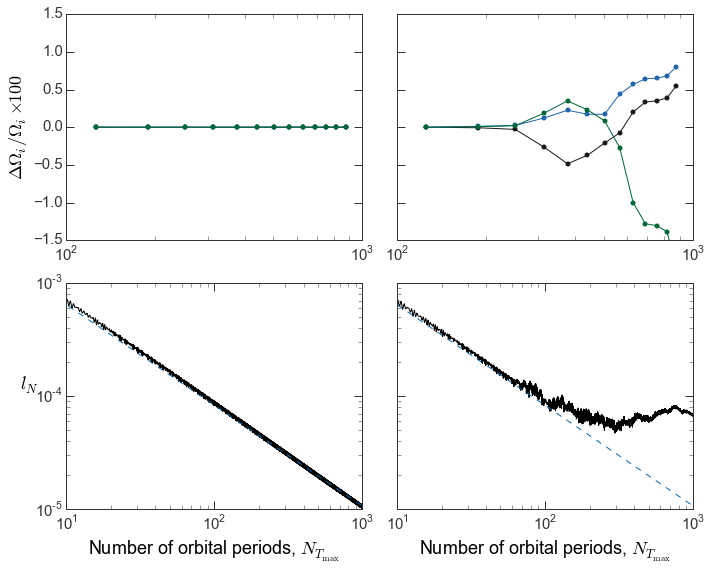

In [43]:
fig,axes = plt.subplots(2,2, figsize=(10,8), sharex='row', sharey='row')

tttt = np.array([(derp[0]+derp[1])/2. for derp in f_ixes])*dt / T.max()

# Freq. diffusion:
for i,f in enumerate([slow_freqs, fast_freqs]):
    for j in range(3):
        mean_f = f[0,sorted_ixes[j]]
        max_x = (f[:,sorted_ixes[j]] - mean_f) / mean_f * 100.
        axes[0,i].semilogx(tttt, max_x, marker='o', linestyle='-')

axes[0,0].set_ylabel(r"$\Delta\Omega_i/\Omega_i \times 100$")

axes[0,0].set_ylim(-1.5,1.5)

# Lyapunov:
axes[1,0].loglog(sl_lyap_ts[1:] / T.max(), sl_LEs[:,sl_ix], 
                 linestyle='-', c='k', marker=None)

axes[1,1].loglog(fa_lyap_ts[1:] / T.max(), fa_LEs[:,sl_ix], 
                 linestyle='-', c='k', marker=None)

tt = np.linspace(1,1E3,100)
axes[1,0].loglog(tt, 0.005/tt**0.89, linestyle='--', c='#0868ac', marker=None)
axes[1,1].loglog(tt, 0.005/tt**0.89, linestyle='--', c='#0868ac', marker=None)

axes[1,0].set_xlim(10,1000)
axes[1,0].set_ylim(1E-5,1E-3)

axes[1,0].set_xlabel(r"Number of orbital periods, $N_{T_{\rm max}}$")
axes[1,1].set_xlabel(r"Number of orbital periods, $N_{T_{\rm max}}$")
axes[1,0].set_ylabel(r"$l_N$", rotation='horizontal')

fig.tight_layout()
# fig.savefig("/Users/adrian/papers/papers/stream-morphology/figures/lyap-orbits.pdf")

## Ensembles

In [75]:
evtime = 20000.

In [76]:
slow_w0,dt,slow_nsteps,slow_apo_ixes = peri_to_apo(slow_fast_w0[0], potential, evolution_time=evtime)
fast_w0,dt,fast_nsteps,fast_apo_ixes = peri_to_apo(slow_fast_w0[1], potential, evolution_time=evtime)

#### Just see how it looks after full integration

In [77]:
slow_ball_w0 = create_ball(slow_w0, potential, m_scale=10000., N=1000)
fast_ball_w0 = create_ball(fast_w0, potential, m_scale=10000., N=1000)

In [78]:
slow_t,sloww = potential.integrate_orbit(slow_w0, dt=dt, nsteps=slow_nsteps, 
                                         Integrator=gi.DOPRI853Integrator)
fast_t,fastw = potential.integrate_orbit(fast_w0, dt=dt, nsteps=fast_nsteps, 
                                         Integrator=gi.DOPRI853Integrator)

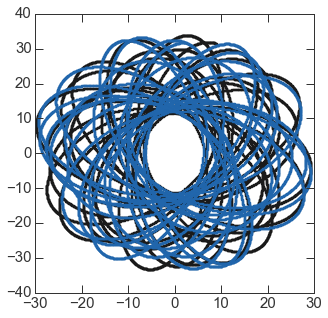

In [82]:
plt.figure(figsize=(5,5))
plt.plot(sloww[:,0,plotix[0]], sloww[:,0,plotix[1]])
plt.plot(fastw[:,0,plotix[0]], fastw[:,0,plotix[1]])

(0, 10000)

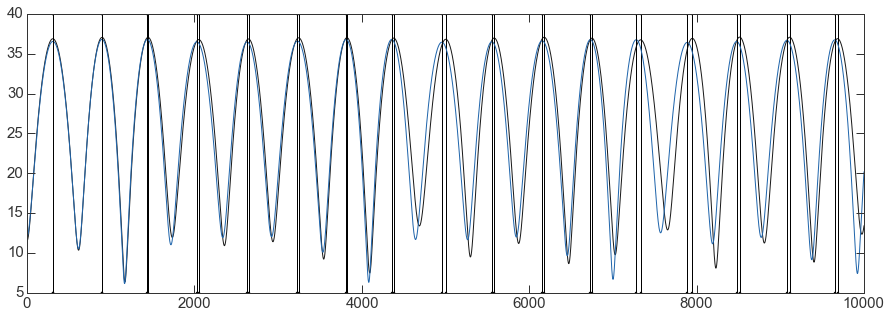

In [83]:
plt.figure(figsize=(15,5))

r = np.sqrt(np.sum(sloww[:,0,:3]**2, axis=-1))
plt.plot(slow_t, r, marker=None)
for ix in slow_apo_ixes:
    plt.axvline(slow_t[ix])

r = np.sqrt(np.sum(fastw[:,0,:3]**2, axis=-1))
plt.plot(fast_t, r, marker=None)
for ix in fast_apo_ixes:
    plt.axvline(fast_t[ix])
    
plt.xlim(0,10000)

In [84]:
slow_ball = fast_ensemble.ensemble_integrate(potential.c_instance, slow_ball_w0.copy(), dt, slow_nsteps, 0.)
fast_ball = fast_ensemble.ensemble_integrate(potential.c_instance, fast_ball_w0.copy(), dt, fast_nsteps, 0.)

In [85]:
slow_ball_aligned = align_ensemble(slow_ball)
fast_ball_aligned = align_ensemble(fast_ball)

In [86]:
jjj = 50

(-50, 50)

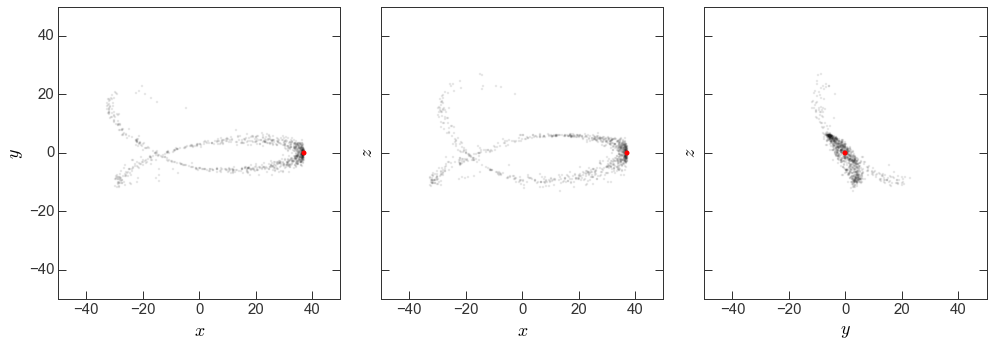

In [87]:
fig = gd.plot_orbits(slow_ball_aligned, linestyle='none', alpha=0.1,
                     subplots_kwargs=dict(sharex=True, sharey=True))
fig = gd.plot_orbits(slow_ball_aligned[0][None], linestyle='none', c='r',
                     alpha=1., marker='o', axes=fig.axes)
fig.axes[0].set_xlim(-jjj,jjj)
fig.axes[0].set_ylim(-jjj,jjj)

(-50, 50)

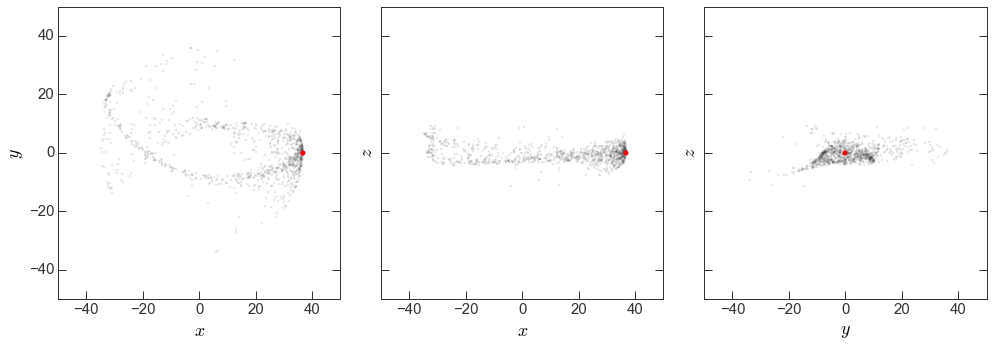

In [88]:
fig = gd.plot_orbits(fast_ball_aligned, linestyle='none', alpha=0.1,
                     subplots_kwargs=dict(sharex=True, sharey=True))
fig = gd.plot_orbits(fast_ball_aligned[0][None], linestyle='none', c='r',
                     alpha=1., marker='o', axes=fig.axes)
fig.axes[0].set_xlim(-jjj,jjj)
fig.axes[0].set_ylim(-jjj,jjj)

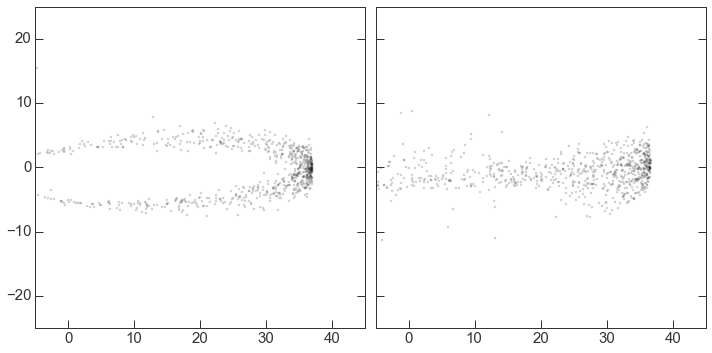

In [89]:
fig,axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].plot(slow_ball_aligned[:,0], slow_ball_aligned[:,1], linestyle='none', alpha=0.2)
axes[1].plot(fast_ball_aligned[:,0], fast_ball_aligned[:,2], linestyle='none', alpha=0.2)

axes[0].set_xlim(-5,45)
axes[0].set_ylim(-25,25)

fig.tight_layout()

---

Now look at KLD vs. time

In [90]:
from sklearn.neighbors import KernelDensity
kde_bandwidth = 10.

predicted_density = lambda x, E0: np.sqrt(E0 - potential(x))

In [91]:
def do_the_kld(ball_w0, apo_ixes, dt=1.):
    ww = np.ascontiguousarray(ball_w0.copy())
    nensemble = ball_w0.shape[0]
    
    # energy of parent orbit
    E0 = float(np.squeeze(potential.total_energy(ww[0,:3],ww[0,3:])))
    
    klds = []
    ts = []
    apo_ixes = np.append([0], apo_ixes)
    t = 0.
    for i,left_step,right_step in zip(range(len(apo_ixes)-1), apo_ixes[:-1], apo_ixes[1:]):
        dstep = right_step - left_step
        www = fast_ensemble.ensemble_integrate(potential.c_instance, ww, dt, dstep, 0.)
#         www = fast_ensemble.ensemble_integrate(potential.c_instance, ball_w0.copy(), dt, right_step, 0.)
        t += dt*dstep
        ts.append(t)

        kde = KernelDensity(kernel='epanechnikov', bandwidth=kde_bandwidth)
        kde.fit(www[:,:3])
        kde_densy = np.exp(kde.score_samples(www[:,:3]))

        num = (np.log10(kde_densy) > -3.75).sum()
        print(i, t, left_step, num)

        p_densy = predicted_density(www[:,:3], E0)
        D = np.log(kde_densy / p_densy)
        KLD = D[np.isfinite(D)].sum() / float(nensemble)
#         klds.append(KLD)
        klds.append(np.log10(kde_densy).max())
        
#         fig,axes = plt.subplots(1,3,figsize=(15,4))
#         align_ww = align_ensemble(www.copy())
#         axes[0].plot(align_ww[:,0], align_ww[:,1], alpha=0.25, linestyle='none')
#         axes[0].plot(align_ww[0,0], align_ww[0,1], alpha=1., linestyle='none', marker='o', c='r')
#         axes[0].set_xlim(-42,42)
#         axes[0].set_ylim(-42,42)
        
#         axes[0].plot(align_ww[:,1], align_ww[:,2], alpha=0.25, linestyle='none')
#         axes[0].plot(align_ww[0,1], align_ww[0,2], alpha=1., linestyle='none', marker='o', c='r')
#         axes[0].set_xlim(-42,42)
#         axes[0].set_ylim(-42,42)
        
#         axes[1].hist(np.log10(kde_densy), bins=np.linspace(-6,-2,35))
        
        ww = www.copy()
    
    return ts, klds

In [92]:
slow_kld_t,slow_klds = do_the_kld(slow_ball_w0, slow_apo_ixes)

0 309.0 0 1001
1 898.0 309 1001
2 1447.0 898 1001
3 2053.0 1447 1000
4 2647.0 2053 999
5 3246.0 2647 979
6 3822.0 3246 981
7 4381.0 3822 949
8 5004.0 4381 902
9 5582.0 5004 884
10 6179.0 5582 818
11 6750.0 6179 841
12 7331.0 6750 732
13 7949.0 7331 748
14 8514.0 7949 704
15 9112.0 8514 637
16 9684.0 9112 652
17 10296.0 9684 519
18 10884.0 10296 616
19 11444.0 10884 504
20 12046.0 11444 459
21 12626.0 12046 463
22 13247.0 12626 393
23 13811.0 13247 492
24 14375.0 13811 302
25 14982.0 14375 327
26 15571.0 14982 237
27 16182.0 15571 284
28 16735.0 16182 395
29 17310.0 16735 0
30 17920.0 17310 204
31 18511.0 17920 0
32 19110.0 18511 187


In [93]:
fast_kld_t,fast_klds = do_the_kld(fast_ball_w0, fast_apo_ixes)

0 310.0 0 1001
1 896.0 310 1001
2 1438.0 896 1001
3 2030.0 1438 1001
4 2630.0 2030 1000
5 3232.0 2630 986
6 3813.0 3232 992
7 4357.0 3813 974
8 4956.0 4357 901
9 5554.0 4956 897
10 6155.0 5554 837
11 6731.0 6155 867
12 7279.0 6731 816
13 7887.0 7279 716
14 8479.0 7887 724
15 9079.0 8479 645
16 9651.0 9079 713
17 10204.0 9651 598
18 10822.0 10204 512
19 11405.0 10822 530
20 12006.0 11405 495
21 12572.0 12006 564
22 13138.0 12572 242
23 13759.0 13138 283
24 14334.0 13759 285
25 14934.0 14334 323
26 15496.0 14934 288
27 16083.0 15496 0
28 16694.0 16083 24
29 17264.0 16694 6
30 17863.0 17264 79
31 18426.0 17863 0
32 19037.0 18426 0


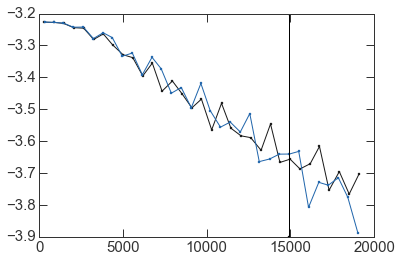

In [94]:
plt.plot(slow_kld_t, slow_klds)
plt.plot(fast_kld_t, fast_klds)
plt.axvline(1/6.7E-5)

---

Figure out how to defined stream observability...

0 0
1 734
2 1468
3 2203
4 2937
5 3671


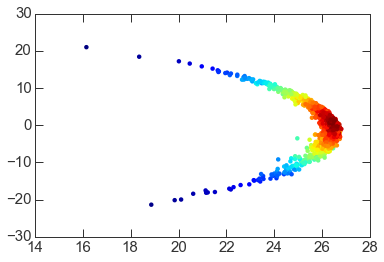

In [17]:
ww = np.ascontiguousarray(slow_ball_w0.copy())
nensemble = slow_ball_w0.shape[0]
E0 = float(np.squeeze(potential.total_energy(ww[0,:3],ww[0,3:])))

step_ixs = np.linspace(0,slow_nsteps,16).astype(int)
dstep = step_ixs[1] - step_ixs[0]
slow_klds = []

for i,step_ix in enumerate(step_ixs):
    ww = fast_ensemble.ensemble_integrate(potential.c_instance, ww, dt, dstep, step_ix*dt)
        
    kde = KernelDensity(kernel='epanechnikov', bandwidth=kde_bandwidth)
    kde.fit(ww[:,:3])
    kde_densy = np.exp(kde.score_samples(ww[:,:3]))

(array([   0.,    3.,    0.,    1.,    2.,    3.,    2.,    2.,    2.,
           3.,    5.,   13.,   13.,   19.,   28.,   33.,   44.,   80.,
         105.,  221.,  420.,    0.,    0.,    0.]),
 array([-5.   , -4.925, -4.85 , -4.775, -4.7  , -4.625, -4.55 , -4.475,
        -4.4  , -4.325, -4.25 , -4.175, -4.1  , -4.025, -3.95 , -3.875,
        -3.8  , -3.725, -3.65 , -3.575, -3.5  , -3.425, -3.35 , -3.275, -3.2  ]),
 <a list of 24 Patch objects>)

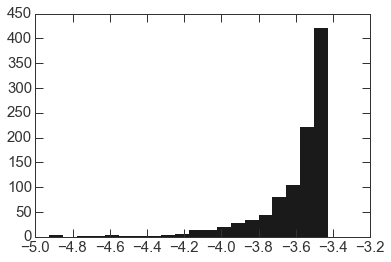

In [21]:
plt.hist(np.log10(kde_densy), bins=np.linspace(-5,-3.2,25))

In [28]:
align_ww = align_ensemble(ww)

<matplotlib.colorbar.Colorbar instance at 0x10e3caea8>

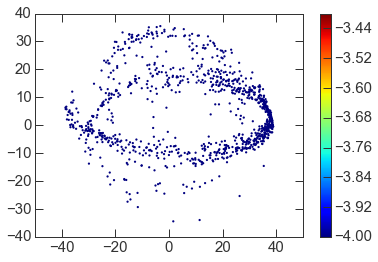

In [29]:
plt.scatter(align_ww[:,0], align_ww[:,1], c=np.log10(kde_densy), marker='.', vmin=-4, vmax=-3.4)
plt.colorbar()

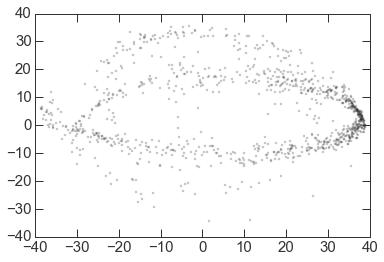

In [30]:
plt.plot(align_ww[:,0], align_ww[:,1], alpha=0.25, linestyle='none')